In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/isot-dataset/data.csv


In [14]:
data_df = pd.read_csv("/kaggle/input/isot-dataset/data.csv")

In [15]:
from sklearn.utils import shuffle

data_df = shuffle(data_df, random_state=42)  # Set random_state for reproducibility

In [16]:
data_df.tail()

,title,text,subject,date,label
11284,Nigeria says U.S. agrees delayed $593 million ...,ABUJA (Reuters) - The United States has formal...,worldnews,"December 27, 2017",1
44732,Boiler Room #62 – Fatal Illusions,Tune in to the Alternate Current Radio Network...,Middle-east,"June 29, 2016",0
38158,ATHEISTS SUE GOVERNOR OF TEXAS Over Display on...,I m convinced the Freedom From Religion group...,Government News,"Feb 27, 2016",0
860,Republican tax plan would deal financial hit t...,WASHINGTON (Reuters) - The Republican tax plan...,politicsNews,"November 2, 2017",1
15795,U.N. refugee commissioner says Australia must ...,SYDNEY (Reuters) - The U.N. High Commissioner ...,worldnews,"November 1, 2017",1


<h1>Importing Bert
</h1>

In [17]:
from transformers import AutoModel, AutoTokenizer
import torch
from tqdm import tqdm

# Load BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [18]:
texts = data_df["text"].tolist()
labels = data_df["label"].tolist()


In [20]:
import torch
from tqdm import tqdm

def get_bert_embeddings(text_list, model, tokenizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    """Extract BERT embeddings for a list of texts using GPU if available."""
    embeddings = []

    # Move the model to GPU
    model.to(device)

    with torch.no_grad():  
        for text in tqdm(text_list, desc="Encoding with BERT"):
            # Tokenize and move input to GPU
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
            
            # Forward pass
            outputs = model(**inputs)
            
            # Extract CLS token embedding and move to CPU before converting to NumPy
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            
            embeddings.append(cls_embedding)

    return embeddings

# Example Usage
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# Compute embeddings on GPU
embeddings = get_bert_embeddings(texts, model, tokenizer)


Using device: cuda


Encoding with BERT: 100%|██████████| 44898/44898 [12:58<00:00, 57.64it/s]


In [22]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")




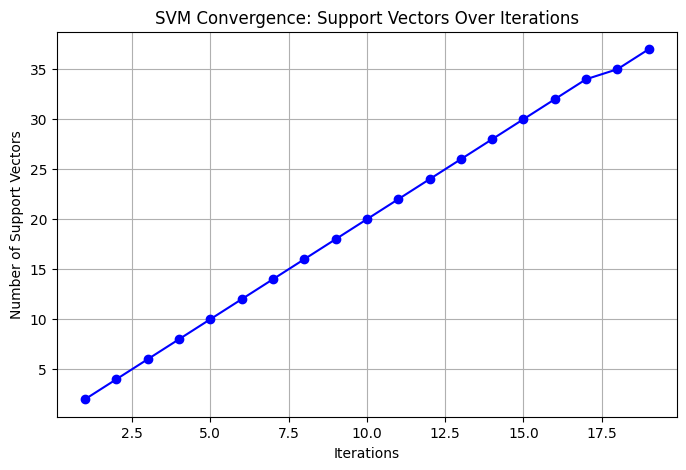

Test Accuracy: 0.8459
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4669
           1       0.88      0.79      0.83      4311

    accuracy                           0.85      8980
   macro avg       0.85      0.84      0.84      8980
weighted avg       0.85      0.85      0.85      8980



In [23]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# Initialize lists for tracking convergence
support_vectors_count = []

# Train SVM iteratively and track the number of support vectors
svm = SVC(kernel="linear", C=1.0, max_iter=1)  # Start with 1 iteration
for i in range(1, 20):  # 20 iterations
    svm.max_iter = i
    svm.fit(X_train, y_train)
    support_vectors_count.append(len(svm.support_))

# Plot convergence (support vectors over iterations)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 20), support_vectors_count, marker="o", linestyle="-", color="blue")
plt.xlabel("Iterations")
plt.ylabel("Number of Support Vectors")
plt.title("SVM Convergence: Support Vectors Over Iterations")
plt.grid()
plt.show()

# Final model evaluation
y_pred = svm.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))


In [29]:
def classify_text(text, model, tokenizer, svm, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Classify new text using BERT (for encoding) and SVM (for classification).
    """
    # Tokenize and get BERT embeddings for the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # Move to CPU before SVM

    # Predict using SVM
    prediction = svm.predict([cls_embedding])[0]
    
    # Return the classification result
    return "True News" if prediction == 1 else "Fake News"


In [30]:
device="cuda" if torch.cuda.is_available() else "cpu"


In [6]:
test_texts = [
     ( "WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific research, infrastructure, public health and environmental protection. “The (Trump) administration has already been willing to say: ‘We’re going to increase non-defense discretionary spending ... by about 7 percent,’” Meadows, chairman of the small but influential House Freedom Caucus, said on the program. “Now, Democrats are saying that’s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I don’t see where the rationale is. ... Eventually you run out of other people’s money,” he said.", "True News"),
    ("Scientists discover a new planet that could potentially support life.", "True News"),
    ("New technology promises to eliminate traffic in major cities by 2030.", "True News"),
    ("Celebrity claims to have discovered the secret to eternal youth.", "True News"),
    ("The stock market hits an all-time high after major global economies recover.", "True News"),
    ("Revolutionary treatment discovered for Alzheimer’s disease, experts say.", "True News"),
    ("A major political figure caught in a bribery scandal that could shake the government.", "True News"),
    ("Global temperatures are at their highest in recorded history, says report.", "True News"),
    ("Elon Musk confirms plans to establish a colony on Mars by 2040.", "True News"),
    ("Thousands of people in the city are facing severe flooding due to heavy rains.", "True News"),
    ("NASA Announces Discovery of Earth-Like Planet in Habitable Zone", "True News"),
    ("Economists Predict Strong Job Growth in the Next Quarter", "True News"),
    ("WHO Confirms Decline in Global COVID-19 Cases Due to Vaccination Efforts", "True News"),
    ("New Study Reveals Climate Change is Accelerating Polar Ice Melting", "True News"),
    ("US and China Sign Trade Agreement Aimed at Reducing Tariffs", "True News"),
    ("Medical Breakthrough: Scientists Develop a New Treatment for Alzheimer’s", "True News"),
    ("Electric Cars Expected to Overtake Gasoline Vehicles by 2035", "True News"),
    ("World Leaders Meet to Discuss Strategies for Reducing Carbon Emissions", "True News"),
    ("Research Confirms Mediterranean Diet Reduces Risk of Heart Disease", "True News"),
    ("Apple Announces New iPhone with Advanced AI Capabilities", "True News"),
    ("Government to Ban All Cash Transactions Starting Next Month", "Fake News"),
    ("New Study Proves That Eating Chocolate Every Day Cures Cancer", "Fake News"),
    ("Aliens Found in Area 51: Secret Documents Leaked by Former Employee", "Fake News"),
    ("5G Towers Are Spreading a New Deadly Virus, Scientists Warn", "Fake News"),
    ("Bill Gates Secretly Controls the Global Weather System", "Fake News"),
    ("Doctors Reveal COVID-19 Vaccines Contain Mind-Control Microchips", "Fake News"),
    ("The Moon Landing Was Faked: New Evidence Surfaces", "Fake News"),
    ("NASA Confirms the Existence of a Hidden Civilization on Mars", "Fake News"),
    ("Scientists Discover a Formula That Guarantees Winning the Lottery", "Fake News"),
    ("Drinking Lemon Juice Every Morning Makes You Live 50 Years Longer", "Fake News"),
]

# Run Predictions
true_labels = []
predicted_labels = []

for text, label in test_texts:
    prediction = classify_text(text, model, tokenizer, svm, device)
    true_labels.append(label)
    predicted_labels.append(prediction)
    print(f"Text: {text}\nTrue Label: {label}\nPrediction: {prediction}\n")

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels) * 100
print(f"\n✅ Model Accuracy on ISOT Test Set: {accuracy:.2f}%")


Text: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support e